🧾**Description**: Getting a rapid understanding of the context of a patient’s overall health has been particularly important
    during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in
    critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in
    distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic
    conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient
    from another medical provider or system. Knowledge about chronic conditions can inform clinical decisions about patient care
    and ultimately improve patient's survival outcomes.

🧭 **Problem Statement**: The target feature is **hospital_death** which is a binary variable. The task is to classify this variable based on the other 84 features step-by-step by going through each day's task. The scoring metric is **Accuracy/Area under ROC curve**.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv(r'C:\Users\ketan\Downloads\Patient_Survival_Detection_dataset.csv')

In [3]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [4]:
raw_data.shape

(91713, 186)

In [5]:
raw_data.isna().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
hospital_death                       0
age                               4228
bmi                               3429
elective_surgery                     0
ethnicity                         1395
gender                              25
height                            1334
hospital_admit_source            21409
icu_admit_source                   112
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
readmission_status                   0
weight                            2720
albumin_apache                   54379
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
apache_post_operative                0
arf_apache                         715
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

In [6]:
raw_data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [8]:
raw_data['readmission_status'].value_counts()

0    91713
Name: readmission_status, dtype: int64

In [9]:
# Removing columns that have more than 30,000 null values and the columns that are not useful.
# We are removing 'bmi' column as well because we already have 'height' and 'weight' columns separately.
threshold = len(raw_data) - 30000
drop_cols = ['encounter_id','patient_id','hospital_id','bmi','icu_id','readmission_status']
data = raw_data.dropna(axis=1, thresh=threshold).drop(drop_cols, axis=1)

In [11]:
data.shape

(91713, 106)

In [14]:
data.describe(include='O')

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
count,90318,91688,70304,91601,91713,91713,90051,90051
unique,6,2,15,5,3,8,11,10
top,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Cardiovascular,Cardiovascular
freq,70684,49469,36962,54060,86183,50586,29999,38816


In [15]:
cat_cols = ['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
for i in cat_cols:
    print(data[i].value_counts())
for i in cat_cols:
    print(data[i].isna().sum())

Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64
M    49469
F    42219
Name: gender, dtype: int64
Emergency Department    36962
Operating Room           9787
Floor                    8055
Direct Admit             6441
Recovery Room            2896
Acute Care/Floor         1910
Other Hospital           1641
Step-Down Unit (SDU)     1131
PACU                     1017
Other ICU                 233
Chest Pain Center         134
ICU to SDU                 45
ICU                        35
Observation                10
Other                       7
Name: hospital_admit_source, dtype: int64
Accident & Emergency         54060
Operating Room / Recovery    18713
Floor                        15611
Other Hospital                2358
Other ICU                      859
Name: icu_admit_source, dtype: int64
admit       86183
transfer     4970
readmit       560
Name: i

In [18]:
data.head(2)

,hospital_death,age,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,0.541667,73.9,113.0,502.01,0,0.0,31.0,2.51,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,36.0,134.0,39.3,0.0,14.1,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,39.5,37.5,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,0,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,0.927778,70.2,108.0,203.01,0,0.0,9.0,0.56,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,33.0,145.0,35.1,1.0,12.7,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,36.3,36.3,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [19]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [20]:
p = list(X_train.columns)

In [21]:
num_cols = [x for x in p if x not in cat_cols]

In [23]:
num_imp = SimpleImputer()
cat_imp = SimpleImputer(strategy='constant',fill_value='Unknown')
enc = OneHotEncoder(drop='first',sparse=False)
# scaler = StandardScaler()
imp_col_tra = ColumnTransformer([('n',num_imp,num_cols),('c',cat_imp,cat_cols)])
X_train_imp = imp_col_tra.fit_transform(X_train)
X_test_imp = imp_col_tra.transform(X_test)
df_train = pd.DataFrame(X_train_imp,columns=num_cols+cat_cols)
df_test = pd.DataFrame(X_test_imp,columns=num_cols+cat_cols)
enc_col_tra = ColumnTransformer([('e',enc,cat_cols)],remainder='passthrough')
X_train_prepro = enc_col_tra.fit_transform(df_train)
X_test_prepro = enc_col_tra.transform(df_test)
# X_train_prepro2 = scaler.fit_transform(X_train_prepro)
# X_test_prepro2 = scaler.transform(X_test_prepro)

In [24]:
#df_X_train_prepro = pd.DataFrame(X_train_prepro)

In [25]:
# df_X_train_prepro.head(2)

In [26]:
import tensorflow as tf
from tensorflow import keras

In [27]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [28]:
# Neural network
model = Sequential()
model.add(Dense(100, input_dim=155, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# # df_y_train = pd.DataFrame(y_train)
# df_X_train_prepro=np.asarray(df_X_train_prepro).astype(int) 
# X_train_tensor = tf.convert_to_tensor(df_X_train_prepro)
# y_train_tensor=np.asarray(y_train_tensor).astype(np.float32) 
# y_train_tensor = tf.convert_to_tensor(df_y_train)
# # X_train_tensor = X_train_prepro.astype(int)
# # y_train_tensor = y_train.astype(int)
# X_test_prepro=np.asarray(X_test_prepro).astype(int) 
# X_test_prepro = tf.convert_to_tensor(X_test_prepro)
# y_test=np.asarray(y_test).astype(np.float32)
# y_test = tf.convert_to_tensor(y_test)

X_train_prepro = X_train_prepro.astype(float)
y_train = y_train.astype(float)

X_test_prepro = X_test_prepro.astype(float)
y_test = y_test.astype(float)

In [31]:
# y_train_tensor.shape
X_train_prepro.shape

(73370, 155)

In [32]:
X_test_prepro.shape

(18343, 155)

In [33]:
history = model.fit(X_train_prepro, y_train,validation_data=(X_test_prepro,y_test), epochs=50, batch_size=64)

Epoch 1/50
1147/1147 [==============================] - 8s 5ms/step - loss: 0.3891 - accuracy: 0.9013 - val_loss: 0.2315 - val_accuracy: 0.9188
Epoch 2/50
1147/1147 [==============================] - 6s 5ms/step - loss: 0.2473 - accuracy: 0.9147 - val_loss: 0.2307 - val_accuracy: 0.9207
Epoch 3/50
1147/1147 [==============================] - 6s 5ms/step - loss: 0.2298 - accuracy: 0.9186 - val_loss: 0.2224 - val_accuracy: 0.9212
Epoch 4/50
1147/1147 [==============================] - 6s 5ms/step - loss: 0.2273 - accuracy: 0.9185 - val_loss: 0.2702 - val_accuracy: 0.9024
Epoch 5/50
1147/1147 [==============================] - 6s 5ms/step - loss: 0.2229 - accuracy: 0.9196 - val_loss: 0.2208 - val_accuracy: 0.9235
Epoch 6/50
1147/1147 [==============================] - 6s 5ms/step - loss: 0.2212 - accuracy: 0.9202 - val_loss: 0.2197 - val_accuracy: 0.9223
Epoch 7/50
1147/1147 [==============================] - 6s 5ms/step - loss: 0.2165 - accuracy: 0.9211 - val_loss: 0.2457 - val_accuracy:

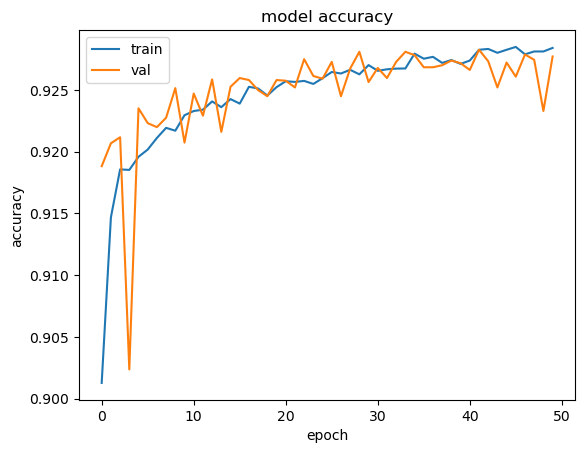

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# If I use scaling methods on this data,my model overfits for some reason. So this is where I will conclude this model.